<a href="https://colab.research.google.com/github/Attilio-Di-Vicino/poople/blob/main/poople.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: **Poople**
**This assignment aims to build a search engine that returns the most similar documents for a given
query**. This project uses embeddings to represent documents and similarity measures to retrieve
the closest matches from a corpus. This can be applied to any domain with text data, such as news
articles, scientific papers, or legal documents.

In [ ]:
!pip install ipywidgets
!pip install gensim
!pip install numpy==1.23.5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import reuters
from collections import Counter
from itertools import chain
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KDTree
from IPython.display import display, clear_output
import ipywidgets as widgets

In [ ]:
nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### **About Dataset (Reuters)**
The Reuters dataset is a collection of documents with news articles.
### **Context**
This dataset contains the
* **ID**
* **categories**
* **raw text**
from each file in NLTK's Reuters corpus.

### **Content**
Each file (row) is a news document.

* **Each document can be classified as one or more categories**.

* Files are also classified as test or train files, which can be found in the ID column and used for textual model building/validation.

* **There are 10,788** total news documents in the file.

Sitography
https://www.kaggle.com/datasets/boldy717/reutersnltk

The following code comes from: https://www.kaggle.com/datasets/boldy717/reutersnltk

In [ ]:
from nltk.corpus import reuters
import pandas as pd

# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe.
reutersDf = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})
reutersDf

,ids,categories,text
0,test/14826,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,test/14828,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...
4,test/14833,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...
...,...,...,...
10783,training/999,"[interest, money-fx]",U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...
10784,training/9992,[earn],KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY\n Q...
10785,training/9993,[earn],TECHNITROL INC &lt;TNL> SETS QUARTERLY\n Qtly...
10786,training/9994,[earn],NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...


In [ ]:
reutersDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ids         10788 non-null  object
 1   categories  10788 non-null  object
 2   text        10788 non-null  object
dtypes: object(3)
memory usage: 253.0+ KB


In [ ]:
reutersDf.describe()

,ids,categories,text
count,10788,10788,10788
unique,10788,468,10657
top,test/14826,[earn],26-FEB-1987\n 26-FEB-1987\n\n
freq,1,3923,7


In [ ]:
def plot_length_of_corpus(corpora, label, tokenized=False):
  # Calculate the length of each text (number of words)
  if tokenized:
    corpus_length = corpora.apply(lambda x: len(x))
  else:
    corpus_length = corpora.apply(lambda x: len(x.split()))
  # View the distribution of text lengths
  plt.figure(figsize=(10, 6))
  plt.hist(corpus_length, bins=50)
  plt.title(f'Distribution of text length {label}')
  plt.xlabel(f'Number of words {label}')
  plt.ylabel(f'Number of documents {label}')
  plt.grid(True)
  plt.show()
  print("Description:")
  print(corpus_length.describe())

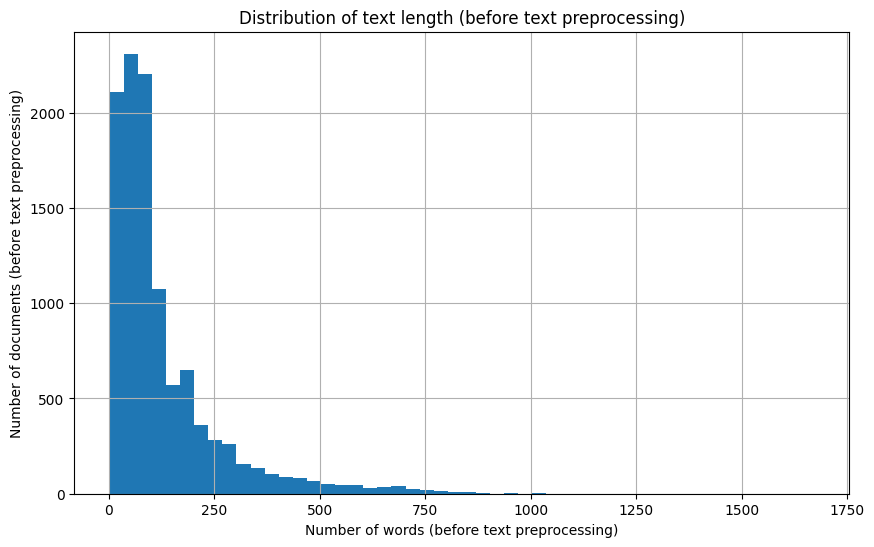

Description:
count    10788.000000
mean       127.762792
std        136.060590
min          2.000000
25%         44.000000
50%         84.000000
75%        158.000000
max       1672.000000
Name: text, dtype: float64


In [ ]:
plot_length_of_corpus(reutersDf['text'], "(before text preprocessing)", False)

#### Frequency Distribution (FD)
* Frequency Distribution (FD) is a simple collection of frequencies of occurrence of items (such as words, tokens, or any other unit) in a single data set.

* It counts how many times each item appears in a corpus or word list.

In [ ]:
def frequency_distribution(corpora, label, n=30, tokenized=False):
  if not tokenized:
    # Tokenize all text in the dataframe
    all_text = ' '.join(corpora)
    tokens = word_tokenize(all_text)
  else:
    tokens = corpora
    tokens = list(chain.from_iterable(tokens))

  # Create a word distribution
  fdist = FreqDist(tokens)

  # View the most common words graph
  plt.figure(figsize=(12, 8))
  fdist.plot(n, cumulative=False)
  plt.title(f'The {n} most common words {label}')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.show()

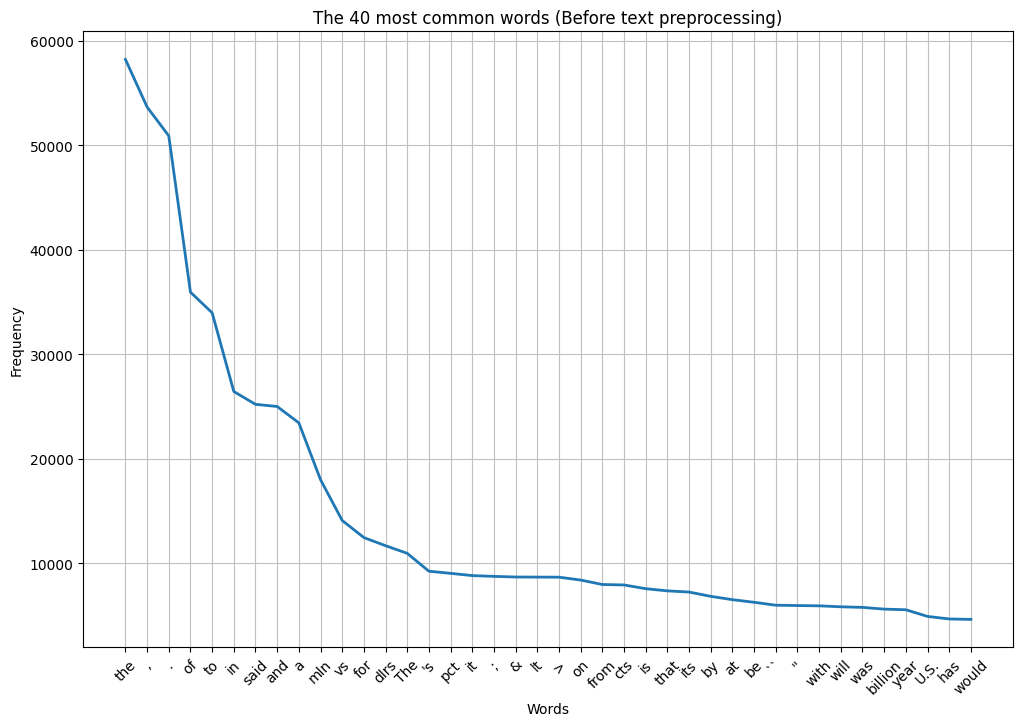

In [ ]:
frequency_distribution(reutersDf['text'], "(Before text preprocessing)", 40, False)

## Clean text

* This corpus, like all, needs to perform few data processing tecnique in order to clean the text.

* There are some markup annotations in the text that we need to remove using regular expressions, but also contractions, HTML entities, spaces or dots.


In [ ]:
regex = [
    ("ain't", "are not"), ("'s", "is"), ("aren't", "are not"), ("can't", "cannot"), ("can't've", "cannot have"),
    ("‘cause", "because"), ("could've", "could have"), ("couldn't", "could not"), ("couldn't've", "could not have"),
    ("didn't", "did not"), ("doesn't", "does not"), ("don't", "do not"), ("hadn't", "had not"), ("hadn't've", "had not have"),
    ("hasn't", "has not"), ("haven't", "have not"), ("he'd", "he would"), ("he'd've", "he would have"), ("he'll", "he will"),
    ("he'll've", "he will have"), ("how'd", "how did"), ("how'd'y", "how do you"), ("how'll", "how will"), ("I'd", "I would"),
    ("I'd've", "I would have"), ("I'll", "I will"), ("I'll've", "I will have"), ("I'm", "I am"), ("I've", "I have"),
    ("isn't", "is not"), ("it'd", "it would"), ("it'd've", "it would have"), ("it'll", "it will"), ("it'll've", "it will have"),
    ("let's", "let us"), ("ma'am", "madam"), ("mayn't", "may not"), ("might've", "might have"), ("mightn't", "might not"),
    ("mightn't've", "might not have"), ("must've", "must have"), ("mustn't", "must not"), ("mustn't've", "must not have"),
    ("needn't", "need not"), ("needn't've", "need not have"), ("o'clock", "of the clock"), ("oughtn't", "ought not"),
    ("oughtn't've", "ought not have"), ("shan't", "shall not"), ("sha'n't", "shall not"), ("shan't've", "shall not have"),
    ("she'd", "she would"), ("she'd've", "she would have"), ("she'll", "she will"), ("she'll've", "she will have"),
    ("should've", "should have"), ("shouldn't", "should not"), ("shouldn't've", "should not have"), ("so've", "so have"),
    ("that'd", "that would"), ("that'd've", "that would have"), ("there'd", "there would"), ("there'd've", "there would have"),
    ("they'd", "they would"), ("they'd've", "they would have"), ("they'll", "they will"), ("they'll've", "they will have"),
    ("they're", "they are"), ("they've", "they have"), ("to've", "to have"), ("wasn't", "was not"), ("we'd", "we would"),
    ("we'd've", "we would have"), ("we'll", "we will"), ("we'll've", "we will have"), ("we're", "we are"), ("we've", "we have"),
    ("weren't", "were not"), ("what'll", "what will"), ("what'll've", "what will have"), ("what're", "what are"),
    ("what've", "what have"), ("when've", "when have"), ("where'd", "where did"), ("where've", "where have"),
    ("who'll", "who will"), ("who'll've", "who will have"), ("who've", "who have"), ("why've", "why have"),
    ("will've", "will have"), ("won't", "will not"), ("won't've", "will not have"), ("would've", "would have"),
    ("wouldn't", "would not"), ("wouldn't've", "would not have"), ("y'all", "you all"), ("y'all'd", "you all would"),
    ("y'all'd've", "you all would have"), ("y'all're", "you all are"), ("y'all've", "you all have"), ("you'd", "you would"),
    ("you'd've", "you would have"), ("you'll", "you will"), ("you'll've", "you will have"), ("you're", "you are"),
    ("you've", "you have")
]
# Replace abbreviations with their full forms
# Example: "10 mln dlrs" -> "10 million dollars"
abbreviations = {
    "mln": "million",
    "dlr": "dollar",
    "dlrs": "dollars",
    "bbl": "barrel",
    "pct": "percent",
    "v": "versus",
    "ct": "court",
    "vs": "versus",
    "shr": "share",
    "inc": "incorporated",
    "U.S.": "United States",
    "U.K.": "United Kingdom"
}

In [ ]:
def clean_text(text):
  # Remove multiple spaces
  # Example: "Hello    world" -> "Hello world"
  text = re.sub(r"\s+", " ", text)
  # Replace HTML entities and fix ticker issues
  # Example: "&lt;Company&gt;" -> "Company"
  text = re.sub(r"&lt;", " ", text)
  text = re.sub(r"&gt;", " ", text)
  text = re.sub(r"lt([A-Z]+)", r"\1", text)  # Example: "ltCSN" -> "CSN"
  # Remove special symbols except periods, commas, and hyphens
  # Example: "Hello @world!" -> "Hello world"
  text = re.sub(r"[^a-zA-Z0-9\s.,-]", "", text)
  # Replace multiple dots with a single one (..... -> .)
  text = re.sub(r"\.{2,}", ".", text)
  # Replace hyphens between numbers with a space
  # Example: "7-4" -> "7 4"
  text = re.sub(r"(\d+)-(\d+)", r"\1 \2", text)
  for abbr, full_form in abbreviations.items():
      text = re.sub(rf"\b{abbr}\b", full_form, text, flags=re.IGNORECASE)
  for pattern, replacement in regex:
      text = re.sub(pattern, replacement, text)
  return text.strip()

# Just for search engine visualization
def title_extraction(text):
  # Extract title from the text
  # The title is assumed to be in all caps before the first newline
  # Example: "BIG NEWS\nThis is the content." -> "BIG NEWS"
  title_match = re.match(r"^(.*?)(\n|$)", text)
  title = title_match.group(1) if title_match else ""
  return title.strip()

In [ ]:
reutersDf['text_cleaned'] = [clean_text(corpus) for corpus in reutersDf['text']]
reutersDf['title'] = [title_extraction(corpus) for corpus in reutersDf['text']]
reutersDf['title'] = [clean_text(corpus) for corpus in reutersDf['title']]

In [ ]:
reutersDf["text"][1] # Before

"CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS\n  A survey of 19 provinces and seven cities\n  showed vermin consume between seven and 12 pct of China's grain\n  stocks, the China Daily said.\n      It also said that each year 1.575 mln tonnes, or 25 pct, of\n  China's fruit output are left to rot, and 2.1 mln tonnes, or up\n  to 30 pct, of its vegetables. The paper blamed the waste on\n  inadequate storage and bad preservation methods.\n      It said the government had launched a national programme to\n  reduce waste, calling for improved technology in storage and\n  preservation, and greater production of additives. The paper\n  gave no further details.\n  \n\n"

In [ ]:
reutersDf['title'][1] # Title

'CHINA DAILY SAYS VERMIN EAT 7 12 percent GRAIN STOCKS'

In [ ]:
reutersDf["text_cleaned"][1] # After

'CHINA DAILY SAYS VERMIN EAT 7 12 percent GRAIN STOCKS A survey of 19 provinces and seven cities showed vermin consume between seven and 12 percent of Chinas grain stocks, the China Daily said. It also said that each year 1.575 million tonnes, or 25 percent, of Chinas fruit output are left to rot, and 2.1 million tonnes, or up to 30 percent, of its vegetables. The paper blamed the waste on inadequate storage and bad preservation methods. It said the government had launched a national programme to reduce waste, calling for improved technology in storage and preservation, and greater production of additives. The paper gave no further details.'

## Tokenization and stop word

* **Hence**, we can proceed with tokenization, lowercasing and stop word removal.

* **Tokenization** is the process of breaking a text into smaller units, called tokens, which can be words, phrases, or even characters. In this case, we are splitting sentences into individual words.  

* **Stop words** are common words like *the is and in* that don’t add much meaning and are usually removed to improve text analysis. We use a predefined list of stop words (from NLTK) and filter them out from our tokenized text.  

So, in the code, we:
1. Tokenize the cleaned text
2. Convert everything to lowercase for consistency
3. Remove stop words to keep only the meaningful words.

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenize the text
# reutersDf['tokens'] = reutersDf['text_cleaned'].apply(lambda x: word_tokenize(x))
reutersDf['tokens'] = reutersDf['text_cleaned'].apply(lambda x: [word.lower() for word in word_tokenize(x)])
stop_words = set(stopwords.words('english'))
reutersDf['tokens'] = [
    [word for word in row if word not in stop_words]
    for row in reutersDf['tokens']
]
print(reutersDf[['tokens']][:10])

                                              tokens
0  [asian, exporters, fear, damage, u.s.-japan, r...
1  [china, daily, says, vermin, eat, 7, 12, perce...
2  [japan, revise, long-term, energy, demand, dow...
3  [thai, trade, deficit, widens, first, quarter,...
4  [indonesia, sees, cpo, price, rising, sharply,...
5  [australian, foreign, ship, ban, ends, nsw, po...
6  [indonesian, commodity, exchange, may, expand,...
7  [sri, lanka, gets, usda, approval, wheat, pric...
8  [western, mining, open, new, gold, mine, austr...
9  [sumitomo, bank, aims, quick, recovery, merger...


## Lemmatization

**Lemmatization** is the process of reducing words to their base or dictionary form (lemma) while considering the word’s part of speech (POS). Unlike stemming, which simply removes suffixes, lemmatization ensures that the word remains meaningful.  

In the code:  
1. Assign **POS tags** to words (like noun, verb, adjective) because lemmatization depends on them.  
2. Apply **WordNet’s lemmatizer**, which converts words to their base form.  
   - Example: *running* → *run*
3. Also remove **punctuation, and non-alphabetic words** to keep only meaningful tokens.

In [ ]:
def get_wordnet_pos(treebank_tag):
  # Convert Treebank POS tags to WordNet POS tags
  # Example: 'J' -> ADJ, 'V' -> VERB
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN

def lemmatizer_text(tokens, stop_words, punctuation):
  # Lemmatize tokens while filtering out stop words and punctuation
  lemmatizer = WordNetLemmatizer()
  lemmatized_text = []
  for doc in tokens:
    # Assign POS tags to words
    tag_token = pos_tag(doc) # Default NOUN
    # Lemmatize words while removing punctuation, and non-alphabetic words
    lm = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tag_token if token not in punctuation and token.isalpha()]
    lemmatized_text.append(lm)
  return lemmatized_text

In [ ]:
punctuation = set(string.punctuation) # String containing all the predefined punctuation characters in Python
reutersDf['processed_text'] = lemmatizer_text(reutersDf['tokens'], stop_words, punctuation)

* After these operations the result is an elaborate corpora

* but we also get some documents in the corpora which have 0 words and that is why we remove these documents

In [ ]:
# Count the empty documents
empty_docs_count = (reutersDf['processed_text'].apply(len) == 0).sum()
print(f"Number of empty documents: {empty_docs_count}")
# Filter out empty documents
reutersDf = reutersDf[reutersDf['processed_text'].apply(len) > 0]
print(f"Remaining documents after removal: {len(reutersDf)}")

Number of empty documents: 61
Remaining documents after removal: 10727


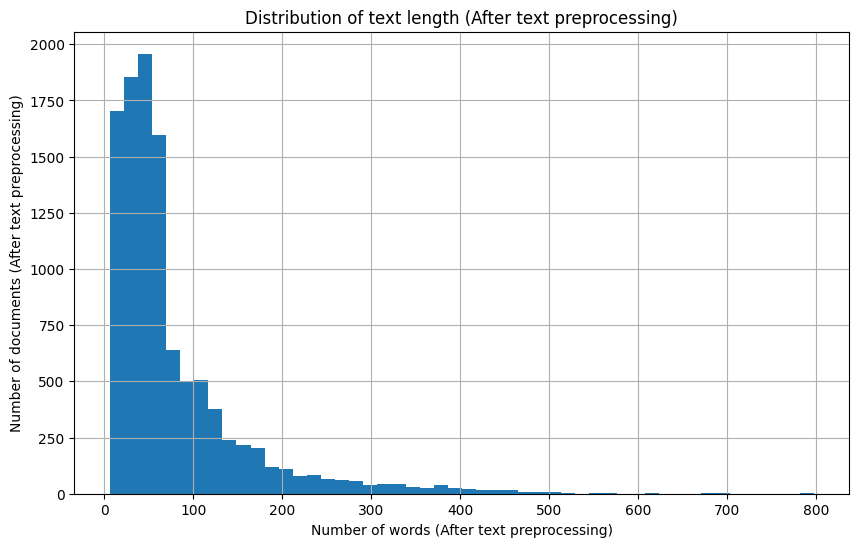

Description:
count    10727.000000
mean        77.674093
std         77.821083
min          6.000000
25%         30.000000
50%         52.000000
75%         94.000000
max        798.000000
Name: processed_text, dtype: float64


In [ ]:
plot_length_of_corpus(reutersDf['processed_text'], "(After text preprocessing)", True)

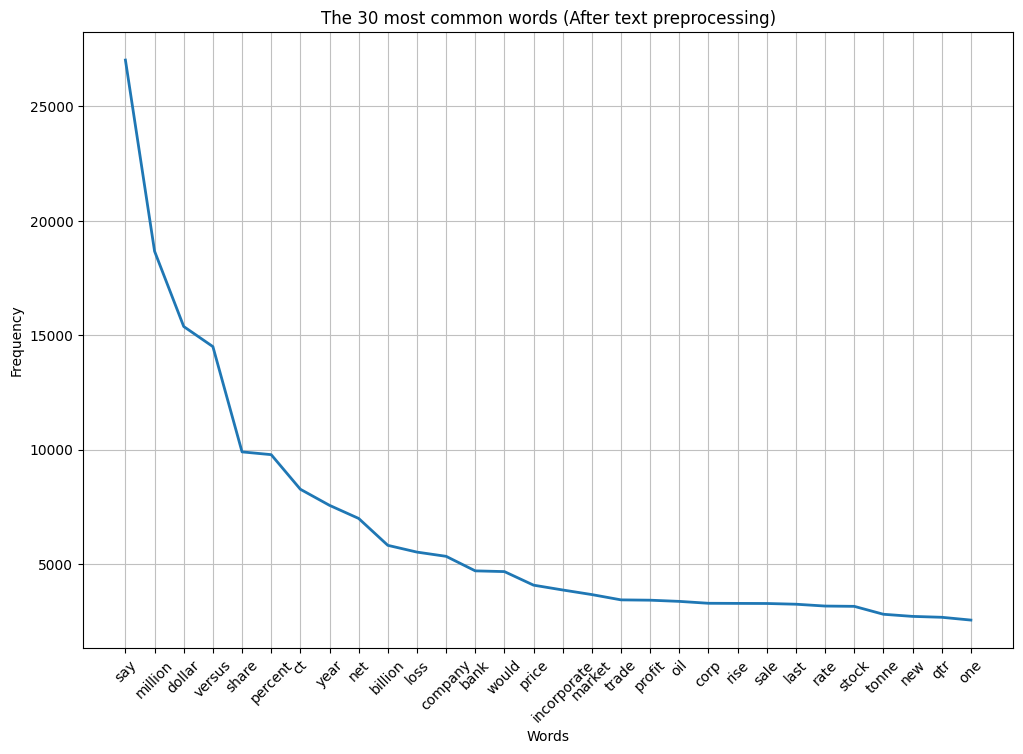

In [ ]:
frequency_distribution(reutersDf['processed_text'], "(After text preprocessing)", 30, True)

### 2. **Document Representation General**

* Document representation methods convert text data into numerical vectors that can be used in machine learning tasks.

* These methods capture semantic meaning, importance, and structure of the text, enabling algorithms to process and understand the content.

### **CBOW (Continuous Bag of Words)**
- **Goal**: Learns word embeddings by predicting a target word based on its context.
- **How it works**: Given a context window of words, CBOW predicts the target word. The learned embeddings capture semantic relationships between words.
- **Usage**: Typically used to generate word vectors, which can be averaged to represent entire documents.

Word2vec (Google, 2013) Uses a shallow neural network to learn word embeddings

Large windows (C = +/- 5) Nearest words are topically related (not similar) words in the same semantic field

In [ ]:
VECTOR_SIZE = 500 # (100 - 1000)

In [ ]:
from gensim.models import Word2Vec

# Training Word2Vec
word2vec_model = Word2Vec(sentences=reutersDf['processed_text'], vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

def avarage_vector(doc, model):
    embeddings = [model.wv[word] for word in doc if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
X_train_wv = [avarage_vector(doc, word2vec_model) for doc in reutersDf['processed_text']]


### **Doc2Vec**
- **Goal**: Extends Word2Vec to generate vector representations for entire documents.
- **How it works**: Tags documents with unique identifiers and trains a model to predict both the words in a document and the document's tag. This results in a vector that captures the semantic meaning of the document.
- **Usage**: Provides fixed-length vectors for entire documents, making it useful for tasks like document classification and clustering.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tag documents for Doc2Vec
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(reutersDf['processed_text'])]

# Training Doc2Vec
doc2vec_model = Doc2Vec(vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4, epochs=40)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
# Extract document vectors
X_train_dv = [doc2vec_model.dv[str(i)] for i in range(len(reutersDf))]

### **TF-IDF (Term Frequency-Inverse Document Frequency)**
- **Goal**: Represents documents by weighing terms based on their frequency within a document and across the corpus.
- **How it works**: Calculates a score for each word based on its frequency in a document (TF) and its rarity across all documents (IDF). Words with high TF-IDF scores are considered important.
- **Usage**: Useful for identifying important words in a document, but doesn’t capture semantic relationships between words.

### TF-IDF Formula

$$
\text{TF-IDF} = \text{TF} \times \text{IDF}
$$

Where:

- **TF (Term Frequency)** is calculated as:

$$
\text{TF}(t, d) = \frac{\text{Number of occurrences of term } t \text{ in document } d}{\text{Total number of terms in document } d}
$$

- **IDF (Inverse Document Frequency)** is calculated as:

$$
\text{IDF}(t) = \log \left( \frac{N}{\text{DF}(t)} \right)
$$

  Where:
  - $N$ is the total number of documents in the corpus.
  - DF($t$) is the number of documents containing the term $t$.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [" ".join(doc) for doc in reutersDf['processed_text']]

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=VECTOR_SIZE)  # 500 features
tfidf_vectors = tfidf_vectorizer.fit_transform(documents)

In [ ]:
# Convert to array for ease of use
X_train_tfidf = tfidf_vectors.toarray()

In [ ]:
print(f"CBOW vector shape: {np.array(X_train_wv).shape}")
print(f"Doc2Vec vector shape: {np.array(X_train_dv).shape}")
print(f"TF-IDF vector shape: {X_train_tfidf.shape}")

CBOW vector shape: (10727, 500)
Doc2Vec vector shape: (10727, 500)
TF-IDF vector shape: (10727, 500)


In [ ]:
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def preprocess_query(query):
    stop_words = set(stopwords.words("english"))
    punctuation = set(string.punctuation)
    clean_query = clean_text(query)
    tokens = word_tokenize(clean_query)
    lemmatized_query = lemmatizer_text([tokens], stop_words, punctuation)
    return lemmatized_query[0]

def get_average_vector(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:  # Check that the token is in the model's vocabulary
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)  # Average of vectors
    else:
        return np.zeros(model.vector_size)  # Null vector if no word is valid

def search_engine(query, top_k=5, model="CBOW", UsingKDTree=False):
    processed_query = preprocess_query(query)
    query_vector = None

    if model == "CBOW":
        query_vector = get_average_vector(processed_query, word2vec_model)
        doc_vectors = np.array(X_train_wv)

    elif model == "Doc2Vec":
        query_vector = doc2vec_model.infer_vector(processed_query).reshape(1, -1)
        doc_vectors = np.array(X_train_dv)

    elif model == "TF-IDF":
        query_text = " ".join(processed_query)
        query_vector = tfidf_vectorizer.transform([query_text])
        doc_vectors = X_train_tfidf

    else:
        return ["Invalid model"]

    # If the query is empty or there are no vectors available, return an error message
    if query_vector is None or query_vector.shape[0] == 0:
        return ["The query did not return a valid vector."]

    query_vector = query_vector.reshape(1, -1)

    if model == "TF-IDF":
        query_vector = query_vector.toarray()

    if UsingKDTree:
        # Use KDTree to find nearest neighbors
        kdtree = KDTree(doc_vectors, metric="euclidean")
        distances, indices = kdtree.query(query_vector, k=top_k)
        similarities = 1 / (1 + distances.flatten())  # Convert distances to similarities
        sorted_indices = np.argsort(similarities)[::-1]
        indices = sorted_indices[:top_k]
    else:
        # Use cosine similarity
        similarities = cosine_similarity(query_vector, doc_vectors).flatten()
        indices = np.argsort(similarities)[::-1][:top_k]  # Get top_k indices sorted by similarity

    results = []
    for idx in indices:
        text = reutersDf.iloc[idx]['text_cleaned']
        text = text.replace(reutersDf.iloc[idx]['title'], "", 1)  # Remove title from body

        result = (
            f"\n\n{reutersDf.iloc[idx]['title'][:500]} (Similarity = {similarities[idx]:.2f})"
            + f" (Category {reutersDf.iloc[idx]['categories']})\n"
            + f"{text[:500]}"
        )
        results.append(result)

    return results

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Title (Poople -> P as Parthenope)
title_label = widgets.HTML(
    value="<h1 style='text-align: center; font-family: Arial, sans-serif;'>"
          "<span style='color: #4285F4;'>P</span>"
          "<span style='color: #DB4437;'>o</span>"
          "<span style='color: #F4B400;'>o</span>"
          "<span style='color: #4285F4;'>p</span>"
          "<span style='color: #0F9D58;'>l</span>"
          "<span style='color: #DB4437;'>e</span>"
          "</h1>",
    layout=widgets.Layout(margin='0 0 20px 0')
)

# Query input widget
# Just some util query
# 1. The biggest gain
# grain planting projections
# corporate earnings report
# global trade agreements
# oil price increase
query_input = widgets.Text(
    value='gold market analysis',  # Example query
    placeholder='Enter your query here...',
    description='Query:',
    layout=widgets.Layout(width='80%', margin='0 auto')
)

# Dropdown for model selection
model_dropdown = widgets.Dropdown(
    options=['CBOW', 'Doc2Vec', 'TF-IDF'],
    value='CBOW',
    description='Model:',
    layout=widgets.Layout(width='80%', margin='10px auto')
)

# Slider for number of results
top_k_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=10,
    step=1,
    description='Top K:',
    layout=widgets.Layout(width='80%', margin='10px auto')
)

# Checkbox for UsingKDTree
UsingKDTree_checkbox = widgets.Checkbox(
    value=False,
    description='Use KDTree',
    layout=widgets.Layout(width='80%', margin='10px auto')
)

results_output = widgets.Output(layout=widgets.Layout(width='80%', margin='20px auto', border='1px solid #ddd', padding='10px'))

# Search button
search_button = widgets.Button(
    description="Search",
    button_style='success',
    tooltip="Perform the search",
    icon='search',
    layout=widgets.Layout(width='20%', margin='0 auto')
)

# Callback function
def on_search_clicked(b):
    with results_output:
        clear_output()  # Clears previous output
        query = query_input.value
        top_k = top_k_slider.value
        model = model_dropdown.value
        UsingKDTree = UsingKDTree_checkbox.value

        if not query.strip():
            print("Please enter a valid query.")
            return

        # Perform the search
        results = search_engine(query, top_k, model, UsingKDTree)
        for res in results:
            print(res)

# Connect the button to the function
search_button.on_click(on_search_clicked)

# Final layout
app = widgets.VBox([
    title_label,
    query_input,
    model_dropdown,
    top_k_slider,
    UsingKDTree_checkbox,
    search_button,
    results_output
])

display(app)

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

# Function to perform t-SNE and display the data
def tsne_visualization(embeddings, words, title):
    tsne = TSNE(n_components=2, random_state=21, perplexity=30, max_iter=300)
    reduced = tsne.fit_transform(np.array(embeddings))

    words_df = pd.DataFrame(reduced, columns=['Dimension 1', 'Dimension 2'])
    words_df['Word'] = words

    fig = px.scatter(words_df, x='Dimension 1', y='Dimension 2', text='Word',
                     title=title,
                     labels={'Dimension 1': 'Dimension 1', 'Dimension 2': 'Dimension 2'})

    fig.update_traces(textposition='top center')
    fig.show()

# Word2Vec (CBOW)
words_cbow = list(word2vec_model.wv.index_to_key)
rep_cbow = [word2vec_model.wv[word] for word in words_cbow]

# Doc2Vec
words_doc2vec = list(doc2vec_model.wv.index_to_key)
rep_doc2vec = [doc2vec_model.wv[word] for word in words_doc2vec]

# TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
rep_tfidf = tfidf_vectorizer.transform(feature_names).toarray()

In [ ]:
tsne_visualization(rep_cbow, words_cbow, "Word2Vec (CBOW) Word Embeddings visualized with t-SNE")

In [ ]:
tsne_visualization(rep_doc2vec, words_doc2vec, "Doc2Vec Word Embeddings visualized with t-SNE")

In [ ]:
tsne_visualization(rep_tfidf, feature_names, "TF-IDF Feature Embeddings visualized with t-SNE")

### Document Evaluation

Document evaluation is the process of assessing the performance of a model or algorithm in tasks such as text classification, information retrieval, or document clustering. The goal is to quantify how well the model is identifying or classifying relevant documents compared to the ground truth or expected results. Evaluation metrics provide a way to objectively measure the effectiveness of a model’s predictions.

### 1. **Precision**
Precision measures the accuracy of the positive predictions made by the model. Specifically, it is the ratio of correctly predicted positive documents (True Positives) to all documents predicted as positive (True Positives + False Positives).

- **What it tells you**: Precision focuses on how many of the predicted relevant documents are actually relevant. High precision means that the model is good at avoiding false positives.

### 2. **Recall**
Recall measures the model’s ability to identify all relevant documents. It is the ratio of correctly predicted positive documents (True Positives) to all the actual relevant documents (True Positives + False Negatives).

- **What it tells you**: Recall focuses on how many of the actual relevant documents the model is able to retrieve. High recall means that the model is good at finding all relevant documents, but may also retrieve some irrelevant ones.

### 3. **F1 Score**
The F1 Score is the harmonic mean of Precision and Recall. It provides a balanced measure that accounts for both the precision and the recall of the model.

- **What it tells you**: The F1 Score is useful when you need to balance both precision and recall, especially when you have imbalanced data or when false positives and false negatives are equally important.

### Precision, Recall, and F1 Score Formulas

1. **Precision** (also called Positive Predictive Value):
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

2. **Recall** (also called Sensitivity or True Positive Rate):
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

3. **F1 Score** (the harmonic mean of Precision and Recall):
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [ ]:
import random

def generate_random_queries(dataset, num_queries=5, max_labels_per_query=3):
    # Extract all unique labels and convert it into a list
    all_labels = list(set(label for labels in dataset['categories'] for label in labels))
    query_set = {}
    for i in range(num_queries):
        # Select a random number of labels for the query
        num_labels = random.randint(1, max_labels_per_query)
        query_labels = random.sample(all_labels, num_labels)
        # Assign an ID to the query
        query_set[i] = query_labels
    return query_set

In [ ]:
def evaluation(query_set, dataset, label_column, text_column, models, top_k=5, UsingKDTree=False):
    # Table to store the results
    results = []
    # Preprocessing: For each category (query)
    for query_label, query_list in query_set.items():
        processed_query = preprocess_query(" ".join(query_list))
        # Retrieve relevant documents
        relevant_labels = dataset[label_column].isin(query_list)  # Edit to manage multiple categories
        relevant_documents = dataset[relevant_labels][text_column]
        for model in models:
            if model == "CBOW":
                query_vector = get_average_vector(processed_query, word2vec_model)
                doc_vectors = np.array(X_train_wv)
            elif model == "Doc2Vec":
                query_vector = doc2vec_model.infer_vector(processed_query).reshape(1, -1)
                doc_vectors = np.array(X_train_dv)
            elif model == "TF-IDF":
                query_text = " ".join(processed_query)
                query_vector = tfidf_vectorizer.transform([query_text])
                doc_vectors = X_train_tfidf
            query_vector = query_vector.reshape(1, -1)
            if model == "TF-IDF":
              query_vector = query_vector.toarray()

            if UsingKDTree:
                # Create KDTree for top_km lookup (if needed)
                kdtree = KDTree(doc_vectors)
                dist, indices = kdtree.query(query_vector, k=top_k)
                indices = indices.flatten()
                retrieved_documents = dataset.iloc[indices]
            else:
                # Simple search by cosine distance
                similarity_scores = cosine_similarity(query_vector, doc_vectors).flatten()
                indices = np.argsort(similarity_scores)[::-1][:top_k]  # Get top_k indices sorted by similarity
                retrieved_documents = dataset.iloc[indices]
            # Fix to access retrieved_labels values ​​correctly
            retrieved_labels = retrieved_documents[label_column].values
            # Fix to avoid wrong size error
            relevant_labels_for_retrieved = dataset.iloc[indices][label_column].values.flatten()

            # true_positives: sum of cases where one of the retrieved labels is in the query list
            true_positives = np.sum([label in query_list for retrieved_labels_item in retrieved_labels for label in retrieved_labels_item])
            # false_positives: sum of cases where a retrieved label is not in the query list
            false_positives = np.sum([label not in query_list for retrieved_labels_item in retrieved_labels for label in retrieved_labels_item])
            # false_negatives: sum of cases where a relevant label was not retrieved
            false_negatives = np.sum([label not in query_list for relevant_labels_item in relevant_labels_for_retrieved for label in relevant_labels_item])
            # False Negatives: comparison between relevant documents and recovered ones
            false_negatives = np.sum([label not in query_list for label in relevant_labels_for_retrieved])

            # Precision, recall and F1-score
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # Add the results to the table
            results.append({
                'query': query_label,
                'model': model,
                'UsingKDTree': UsingKDTree,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'top_k': top_k
            })

    results_df = pd.DataFrame(results)
    # Calculate the averages for each combination of model and KDTree
    average_results = results_df.groupby(['model', 'UsingKDTree'], as_index=False).agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1_score': 'mean'
    })
    return results_df, average_results

query_set = {
    "grain": ["grain", "corn", "rice", "wheat"],
    "earn": ["earn", "profits", "earnings"],
    "grain": ['grain', 'oilseed', 'ship'],
    "coffee": ["coffee", "beverage", "roast", "caffeine"],
    "oilseed": ["oilseed", "soybean", "canola"],
    "gold": ["gold"]
}
# query_set = generate_random_queries(reutersDf, num_queries=5, max_labels_per_query=3)

models = ["CBOW", "Doc2Vec", "TF-IDF"]
top_k = 10

# Function call for both KDTree modes
results_kdtree_true, average_results_kdtree_true = evaluation(query_set, reutersDf, label_column="categories", text_column="text", models=models, top_k=top_k, UsingKDTree=True)
results_kdtree_false, average_results_kdtree_false = evaluation(query_set, reutersDf, label_column="categories", text_column="text", models=models, top_k=top_k, UsingKDTree=False)

# Combine the results
results_df = pd.concat([results_kdtree_true, results_kdtree_false], ignore_index=True)
avg_df = pd.concat([average_results_kdtree_true, average_results_kdtree_false], ignore_index=True)

# Visualizza i risultati
print(results_df)
print("Average:")
print(avg_df)

      query    model  UsingKDTree  precision    recall  f1_score  top_k
0     grain     CBOW         True   0.388889  0.583333  0.466667     10
1     grain  Doc2Vec         True   0.000000  0.000000  0.000000     10
2     grain   TF-IDF         True   1.000000  0.677419  0.807692     10
3      earn     CBOW         True   1.000000  0.500000  0.666667     10
4      earn  Doc2Vec         True   1.000000  0.500000  0.666667     10
5      earn   TF-IDF         True   1.000000  0.500000  0.666667     10
6    coffee     CBOW         True   0.133333  0.166667  0.148148     10
7    coffee  Doc2Vec         True   0.000000  0.000000  0.000000     10
8    coffee   TF-IDF         True   0.900000  0.473684  0.620690     10
9   oilseed     CBOW         True   0.125000  0.230769  0.162162     10
10  oilseed  Doc2Vec         True   0.133333  0.166667  0.148148     10
11  oilseed   TF-IDF         True   0.593750  0.655172  0.622951     10
12     gold     CBOW         True   0.909091  0.500000  0.645161

## Conclusions

* By giving **human feedback**, we found that **performance is good** when we use **cosine similarity** to compute the distance, using **TF-IDF** and **CBOW** as word embeddings.

* **However**, although the evaluation **metrics suggest similar results for TF-IDF regardless of whether we use cosine or Euclidean distance, this does not seem to be confirmed by human judgments**